In [112]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [209]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [210]:
case = "case30"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

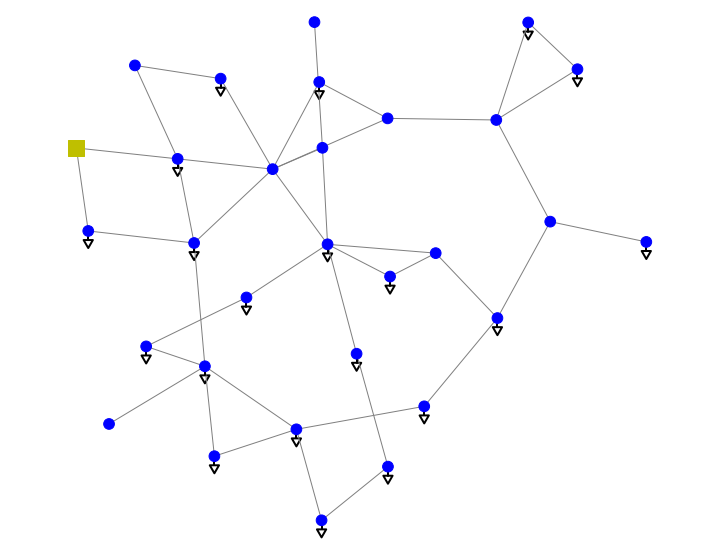

<AxesSubplot:>

In [211]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [212]:
n = len(net.bus)

#### Generators

In [213]:
gen_df_list = []
gen_name_list = ["ext_grid", "gen", "sgen"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [214]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,80.0,0.0,150.0,-20.0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0
1,0,1,80.0,0.0,60.0,-20.0,gen,0.0,1.75,0.01750,0.0,0.0,0.0
2,1,21,50.0,0.0,62.5,-15.0,gen,0.0,1.00,0.06250,0.0,0.0,0.0
3,2,26,55.0,0.0,48.7,-15.0,gen,0.0,3.25,0.00834,0.0,0.0,0.0
4,3,22,30.0,0.0,40.0,-10.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0
5,4,12,40.0,0.0,44.7,-15.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0


#### Bus loads

In [215]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [216]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,21.7,12.7
2,2.4,1.2
3,7.6,1.6
4,0.0,0.0
5,0.0,0.0
6,22.8,10.9
7,30.0,30.0
8,0.0,0.0
9,5.8,2.0


#### Admittance matrices

In [217]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [218]:
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [219]:
G_row_sums = np.sum(G_val, axis=1)
B_row_sums = np.sum(B_val, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        g = shunt_row["p_mw"].to_numpy()[0] / net.sn_mva
        b = -shunt_row["q_mvar"].to_numpy()[0] /net.sn_mva
    G_val[i][i] = g - G_row_sums[i]
    B_val[i][i] = b - B_row_sums[i]

## Variables

In [220]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [221]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [222]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [223]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [224]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,80.0,0.0,150.0,-20.0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0
1,0,1,80.0,0.0,60.0,-20.0,gen,0.0,1.75,0.01750,0.0,0.0,0.0
2,1,21,50.0,0.0,62.5,-15.0,gen,0.0,1.00,0.06250,0.0,0.0,0.0
3,2,26,55.0,0.0,48.7,-15.0,gen,0.0,3.25,0.00834,0.0,0.0,0.0
4,3,22,30.0,0.0,40.0,-10.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0
5,4,12,40.0,0.0,44.7,-15.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0


## Constraints

### SOCP

In [225]:
X = cp.Variable((n,n), hermitian=True)
constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP

In [251]:
constraints = [X >> 0]

In [252]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [253]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [254]:
constraints += [ X[0][0] == 1 ]

In [255]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [256]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0))
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0))

In [257]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [258]:
prob.is_dcp()

True

In [259]:
prob.is_dpp()

True

In [260]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)

The optimal value is 575.4989912834924
A solution X is
[[1.        +0.00000000e+00j 0.99931908+1.45458506e-02j
  0.98867972+4.05908157e-02j 0.98717121+4.83195646e-02j
  0.98393616+4.25572033e-02j 0.98057133+5.48265584e-02j
  0.97148781+5.84721252e-02j 0.96799025+6.16768012e-02j
  0.99619674+7.23715254e-02j 1.00438148+8.15617470e-02j
  0.99619673+7.23715250e-02j 1.0250588 +8.00070542e-02j
  1.07453422+5.99930624e-02j 1.01292703+8.89122188e-02j
  1.01498396+8.52630426e-02j 1.00879396+8.52456721e-02j
  1.00018493+8.59297733e-02j 0.99759876+9.56624352e-02j
  0.99108682+9.87277508e-02j 0.99345474+9.53485924e-02j
  1.01272954+8.29992565e-02j 1.01925648+8.15508625e-02j
  1.03028717+6.85956864e-02j 1.0160824 +7.22789968e-02j
  1.02991334+4.66558973e-02j 1.01229249+5.31883726e-02j
  1.04668145+2.60741029e-02j 0.98573988+5.52707472e-02j
  1.02654979+4.68075542e-02j 1.01464913+6.09834835e-02j]
 [0.99931908-1.45458506e-02j 0.9988502 +0.00000000e+00j
  0.98859693+2.61819890e-02j 0.98720188+3.392741

In [262]:
np.abs(np.linalg.eigvalsh(X.value))

array([1.33580333e-10, 1.28027445e-10, 1.27156010e-10, 1.18458658e-10,
       1.16393526e-10, 1.13868493e-10, 1.10722873e-10, 1.03606410e-10,
       1.02167955e-10, 9.84738255e-11, 9.54014451e-11, 9.09047991e-11,
       8.18318200e-11, 8.07060407e-11, 6.80425184e-11, 4.73020584e-11,
       3.48171167e-11, 2.23355714e-11, 1.85381049e-11, 2.47161789e-11,
       5.95233396e-11, 9.45696294e-11, 2.12075443e-10, 2.70366937e-10,
       7.22671920e-10, 3.73553934e-09, 8.11043366e-09, 8.60012766e-08,
       6.89414380e-03, 3.05326894e+01])

In [263]:
# recover V by diagonalization
(eigen_val, eigen_vec) = np.linalg.eigh(X.value)
V = np.sqrt(eigen_val[n-1]) * eigen_vec[:,n-1]

# V * np.conj(V.reshape(-1,1))

In [267]:
print(p_g.value)
print(q_g.value)

[[0.43605531]
 [0.57870451]
 [0.23134763]
 [0.32849112]
 [0.16929474]
 [0.1748033 ]]
[[-0.05937256]
 [ 0.25142069]
 [ 0.33999673]
 [ 0.21118399]
 [ 0.07438859]
 [ 0.42233926]]


In [268]:
prob.status

'optimal'

In [269]:
# sfm = SolutionFilesManager(folder, case, case_type, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Verify constraints with original solution

In [270]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")
_, V_orig, p_orig, q_orig = sfm.load_solution()

In [271]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)
print(X_orig)

[[1.        +0.00000000e+00j 0.99930994+1.45432498e-02j
  0.98865292+4.05820096e-02j 0.98713878+4.83089628e-02j
  0.98391418+4.25519839e-02j 0.98053684+5.48162984e-02j
  0.97145806+5.84640788e-02j 0.96795466+6.16666651e-02j
  0.99614153+7.23630185e-02j 1.00431542+8.15541379e-02j
  0.99614153+7.23630185e-02j 1.02496564+7.99883728e-02j
  1.07439055+5.99692141e-02j 1.01283704+8.88953596e-02j
  1.01489769+8.52484376e-02j 1.0087118 +8.52323450e-02j
  1.00011372+8.59208556e-02j 0.99751856+9.56514274e-02j
  0.99101048+9.87184710e-02j 0.9933809 +9.53397968e-02j
  1.01266094+8.29903382e-02j 1.01918743+8.15413753e-02j
  1.03021031+6.85831776e-02j 1.01600951+7.22677013e-02j
  1.0298411 +4.66426632e-02j 1.01221904+5.31757411e-02j
  1.04661016+2.60592701e-02j 0.98570146+5.52589343e-02j
  1.02647724+4.67943128e-02j 1.01457584+6.09713075e-02j]
 [0.99930994-1.45432498e-02j 0.99883186+0.00000000e+00j
  0.98856088+2.61757792e-02j 0.98716017+3.39194208e-02j
  0.98385406+2.82133108e-02j 0.98065741+4.05182

In [272]:
print(p_orig)
print(q_orig)

[[0.43605295]
 [0.57870431]
 [0.23134844]
 [0.32849022]
 [0.16929476]
 [0.17480426]]
[[-0.05907916]
 [ 0.25161051]
 [ 0.33994003]
 [ 0.21108756]
 [ 0.07441423]
 [ 0.37071009]]


In [273]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([p_orig[k] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_orig[i][i] + np.sum([G_val[i][j] * np.real(X_orig[i][j]) + B_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([q_orig[k] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_orig[i][i] + np.sum([-B_val[i][j] * np.real(X_orig[i][j]) + G_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))

active 0
[0.43605295]
(0.4360533464677383+0j)
reactive 0
[-0.05907916]
(-0.059079202963765454+0j)
active 1
[0.36170431]
(0.3617048861683365+0j)
reactive 1
[0.12461051]
(0.12460998619403085+0j)
active 2
[-0.024]
(-0.023999728473907744+0j)
reactive 2
[-0.012]
(-0.01200001919786331+0j)
active 3
[-0.076]
(-0.0760002574201355+0j)
reactive 3
[-0.016]
(-0.015999840253151376+0j)
active 4
[0.]
(8.667481044000169e-08+0j)
reactive 4
[0.]
(-3.148205252045955e-08+0j)
active 5
[0.]
(-4.753311202421173e-07+0j)
reactive 5
[0.]
(5.936412605933583e-08+0j)
active 6
[-0.228]
(-0.2279998254023976+0j)
reactive 6
[-0.109]
(-0.10900000218313721+0j)
active 7
[-0.3]
(-0.29999973658849655+0j)
reactive 7
[-0.3]
(-0.2999999317627271+0j)
active 8
[0.]
(-1.7789673369128511e-07+0j)
reactive 8
[0.]
(9.219096597234966e-09+0j)
active 9
[-0.058]
(-0.05799908132294007+0j)
reactive 9
[-0.02]
(-0.020000161991355014+0j)
active 10
[0.]
0j
reactive 10
[0.]
0j
active 11
[-0.112]
(-0.11199964731868217+0j)
reactive 11
[-0.075]
(-